In [64]:
import pandas as pd
import glob
import os
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Aggregating data from all results: 

In [65]:

RESULTS_DIR = "imsbs/paper"

files = glob.glob(os.path.join(RESULTS_DIR, "*.csv"))

print("Found files:", files)

dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df["time_s"] = df["time_s"].astype(float)
df["beam_width"] = df["beam_width"].astype(int)
df["length"] = df["length"].astype(int)
df["feasible"] = df["feasible"].astype(int)  

df[["prefix", "num_seq", "len_seq", "sigma", "inst_num"]] = (
    df["filename"].str.replace(".txt", "", regex=False).str.split("_", expand=True)
)


df = df.astype({
    "num_seq": int,
    "len_seq": int,
    "sigma": int,
    "inst_num": int
})


df = df.drop(columns=["prefix", "filename"])

df = df.rename(columns={
    "num_seq": "number_of_sequences",
    "len_seq": "length_per_sequence",
    "inst_num": "instance_number"
})

print(df.info())
df.head()


Found files: ['imsbs/paper\\new_combined_beamsearch+imbs_results.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sigma                20400 non-null  int32  
 1   beam_width           20400 non-null  int32  
 2   func                 20400 non-null  object 
 3   heuristic            20400 non-null  object 
 4   length               20400 non-null  int32  
 5   time_s               20400 non-null  float64
 6   feasible             20400 non-null  int32  
 7   number_of_sequences  20400 non-null  int32  
 8   length_per_sequence  20400 non-null  int32  
 9   instance_number      20400 non-null  int32  
dtypes: float64(1), int32(7), object(2)
memory usage: 1.0+ MB
None


,sigma,beam_width,func,heuristic,length,time_s,feasible,number_of_sequences,length_per_sequence,instance_number
0,2,1,beam_search_glcs,h2,3,0.0025,1,10,1000,0
1,2,1,imbs_glcs,h2,8,0.0290,1,10,1000,0
2,2,10,beam_search_glcs,h2,3,0.0040,1,10,1000,0
3,2,10,imbs_glcs,h2,8,0.1801,1,10,1000,0
4,2,50,beam_search_glcs,h2,3,0.0030,1,10,1000,0


In [66]:
dp_df = pd.read_csv("basic-dp.csv", sep="\t")

dp_df[["number_of_sequences", "length_per_sequence", "sigma", "instance_number"]] = (
    dp_df["file"].str.split("_", expand=True)
)

dp_df = dp_df.astype({
    "number_of_sequences": int,
    "length_per_sequence": int,
    "sigma": int,
    "instance_number": int,
    "obj": int,
    "time": float,
    "feasible": bool
})

dp_df = dp_df.rename(columns={
    "obj": "length",
    "time": "time_s",
    "file": "filename"
})

dp_df = dp_df.drop(columns=["filename"])

dp_df["func"] = "dp"
dp_df["heuristic"] = "dp"   # placeholder, keeps schema aligned
dp_df["beam_width"] = None  # not applicable for DP

dp_df.head()

,length,time_s,feasible,number_of_sequences,length_per_sequence,sigma,instance_number,func,heuristic,beam_width
0,80,0.09,True,2,100,2,0,dp,dp,None
1,76,0.09,True,2,100,2,1,dp,dp,None
2,79,0.08,True,2,100,2,2,dp,dp,None
3,80,0.09,True,2,100,2,3,dp,dp,None
4,76,0.08,True,2,100,2,4,dp,dp,None


In [67]:
common_cols = [
    "func", "heuristic", "beam_width",
    "length", "time_s", "feasible",
    "number_of_sequences", "length_per_sequence", "sigma", "instance_number"
]

df = df[common_cols]
dp_df = dp_df[common_cols]

all_results = pd.concat([df, dp_df], ignore_index=True)

print(all_results["func"].value_counts())

temp = all_results

all_results


func
beam_search_glcs    10800
imbs_glcs            9600
dp                     60
Name: count, dtype: int64


,func,heuristic,beam_width,length,time_s,feasible,number_of_sequences,length_per_sequence,sigma,instance_number
0,beam_search_glcs,h2,1,3,0.0025,1,10,1000,2,0
1,imbs_glcs,h2,1,8,0.0290,1,10,1000,2,0
2,beam_search_glcs,h2,10,3,0.0040,1,10,1000,2,0
3,imbs_glcs,h2,10,8,0.1801,1,10,1000,2,0
4,beam_search_glcs,h2,50,3,0.0030,1,10,1000,2,0
...,...,...,...,...,...,...,...,...,...,...
20455,dp,dp,None,31,0.0100,1,2,50,4,5
20456,dp,dp,None,30,0.0100,1,2,50,4,6
20457,dp,dp,None,31,0.0100,1,2,50,4,7
20458,dp,dp,None,30,0.0100,1,2,50,4,8


# Comparison with DP for m=2: 

In [68]:
# 1) Copy master DF to be safe
df_all = all_results.copy()

# 2) Separate DP results
df_dp = df_all[df_all["func"] == "dp"].copy()

# 3) Extract the "instance signature" (tuple of identifying params)
instance_keys = ["number_of_sequences", "length_per_sequence", "sigma", "instance_number"]

# All instances that DP solved
dp_instances = set(tuple(row) for row in df_dp[instance_keys].to_numpy())

# 4) Filter beam/IMBS results to those same instances
df_bi = df_all[df_all["func"] != "dp"].copy()
df_bi = df_bi[df_bi[instance_keys].apply(tuple, axis=1).isin(dp_instances)]

# 5) Recombine for comparison
df_compare = pd.concat([df_dp, df_bi], ignore_index=True)

print("DP instances:", len(dp_instances))
print("DP results:", df_dp.shape)
print("Filtered beam/IMBS results:", df_bi.shape)
print("Combined compare DF:", df_compare.shape)
df_compare


DP instances: 60
DP results: (60, 10)
Filtered beam/IMBS results: (3060, 10)
Combined compare DF: (3120, 10)


,func,heuristic,beam_width,length,time_s,feasible,number_of_sequences,length_per_sequence,sigma,instance_number
0,dp,dp,None,80,0.0900,1,2,100,2,0
1,dp,dp,None,76,0.0900,1,2,100,2,1
2,dp,dp,None,79,0.0800,1,2,100,2,2
3,dp,dp,None,80,0.0900,1,2,100,2,3
4,dp,dp,None,76,0.0800,1,2,100,2,4
...,...,...,...,...,...,...,...,...,...,...
3115,beam_search_glcs,h8,1000,28,0.0135,1,2,50,4,9
3116,imbs_glcs,h8,1000,28,0.0130,1,2,50,4,9
3117,beam_search_glcs,h8,2500,28,0.0140,1,2,50,4,9
3118,imbs_glcs,h8,2500,28,0.0151,1,2,50,4,9


In [69]:
keys = ["number_of_sequences", "length_per_sequence", "sigma"]

# basic group summary: how many instances and which instance_numbers exist in each group
grp_summary = (
    df_compare
    .groupby(keys, as_index=False)
    .agg(
        n_instances=("instance_number", "nunique"),
        instance_ids=("instance_number", lambda x: sorted(x.unique()))
    )
)
print(grp_summary.head())


   number_of_sequences  length_per_sequence  sigma  n_instances  \
0                    2                   50      2           10   
1                    2                   50      4           10   
2                    2                  100      2           10   
3                    2                  100      4           10   
4                    2                  200      2           10   

                     instance_ids  
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  


In [70]:
by_func = (
    df_compare
    .groupby(keys + ["func"])
    .agg(
        length_mean=("length", "mean"),
        length_max=("length", "max"),
        time_mean=("time_s", "mean"),
        feasible_rate=("feasible", "mean")  # 0–1 fraction
    )
    .reset_index()
)

# Optional: pivot for side-by-side comparison across algorithms
by_func_pivot = (
    by_func
    .pivot(index=keys, columns="func", values=["length_mean", "length_max", "time_mean", "feasible_rate"])
)
# If you dislike a MultiIndex on columns:
by_func_pivot.columns = ["__".join(col).strip() for col in by_func_pivot.columns.to_flat_index()]
by_func_pivot = by_func_pivot.reset_index()

by_func_pivot


,number_of_sequences,length_per_sequence,sigma,length_mean__beam_search_glcs,length_mean__dp,length_mean__imbs_glcs,length_max__beam_search_glcs,length_max__dp,length_max__imbs_glcs,time_mean__beam_search_glcs,time_mean__dp,time_mean__imbs_glcs,feasible_rate__beam_search_glcs,feasible_rate__dp,feasible_rate__imbs_glcs
0,2,50,2,31.529630,38.1,33.358333,38.0,40.0,38.0,0.007484,0.011,0.016320,1.0,1.0,1.0
1,2,50,4,29.155556,30.3,29.054167,32.0,32.0,32.0,0.131204,0.010,0.077343,1.0,1.0,1.0
2,2,100,2,44.044444,77.4,60.329167,78.0,80.0,78.0,0.202782,0.088,0.268837,1.0,1.0,1.0
3,2,100,4,59.774074,62.3,59.520833,66.0,66.0,66.0,1.170702,0.067,0.509071,1.0,1.0,1.0
4,2,200,2,75.940741,156.4,108.025000,160.0,161.0,160.0,1.461908,0.604,2.463202,1.0,1.0,1.0
5,2,200,4,99.911111,127.2,108.345833,129.0,132.0,129.0,3.652371,0.464,3.208355,1.0,1.0,1.0


# TODO: Currently using MAX length of each algorithm/heuristic/beam width combination to compare with DP solution 

In [71]:
# --- 1) Pivot so DP's length is side by side with others ---
per_instance = (
    df_compare
    .groupby(["number_of_sequences", "length_per_sequence", "sigma", "instance_number", "func"])
    .agg(length=("length", "max")) # TODO: Consult, mean or max?
    .reset_index()
)
per_instance

,number_of_sequences,length_per_sequence,sigma,instance_number,func,length
0,2,50,2,0,beam_search_glcs,24
1,2,50,2,0,dp,36
2,2,50,2,0,imbs_glcs,29
3,2,50,2,1,beam_search_glcs,36
4,2,50,2,1,dp,37
...,...,...,...,...,...,...
175,2,200,4,8,dp,129
176,2,200,4,8,imbs_glcs,129
177,2,200,4,9,beam_search_glcs,121
178,2,200,4,9,dp,126


func  number_of_sequences  length_per_sequence  sigma  instance_number  \
0                       2                   50      2                0   
1                       2                   50      2                1   
2                       2                   50      2                2   
3                       2                   50      2                3   
4                       2                   50      2                4   

func  beam_search_glcs  dp  imbs_glcs  beam_search_glcs_ratio  imbs_glcs_ratio  
0                   24  36         29                0.666667         0.805556  
1                   36  37         37                0.972973         1.000000  
2                   36  39         36                0.923077         0.923077  
3                   38  38         38                1.000000         1.000000  
4                   37  38         37                0.973684         0.973684  


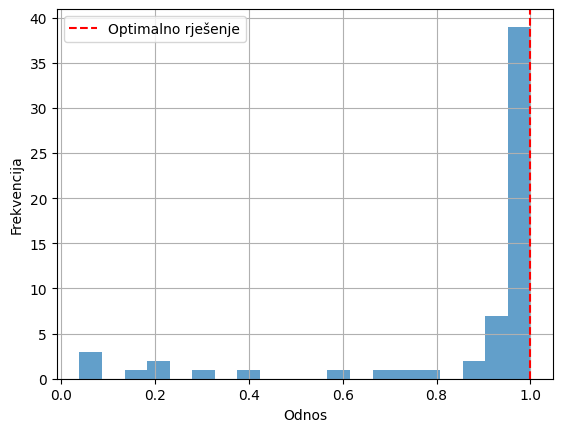

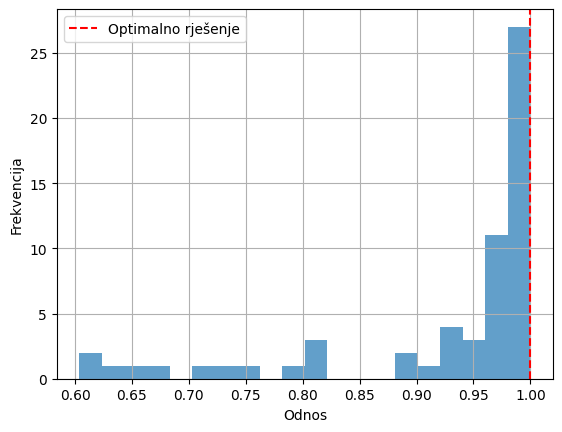

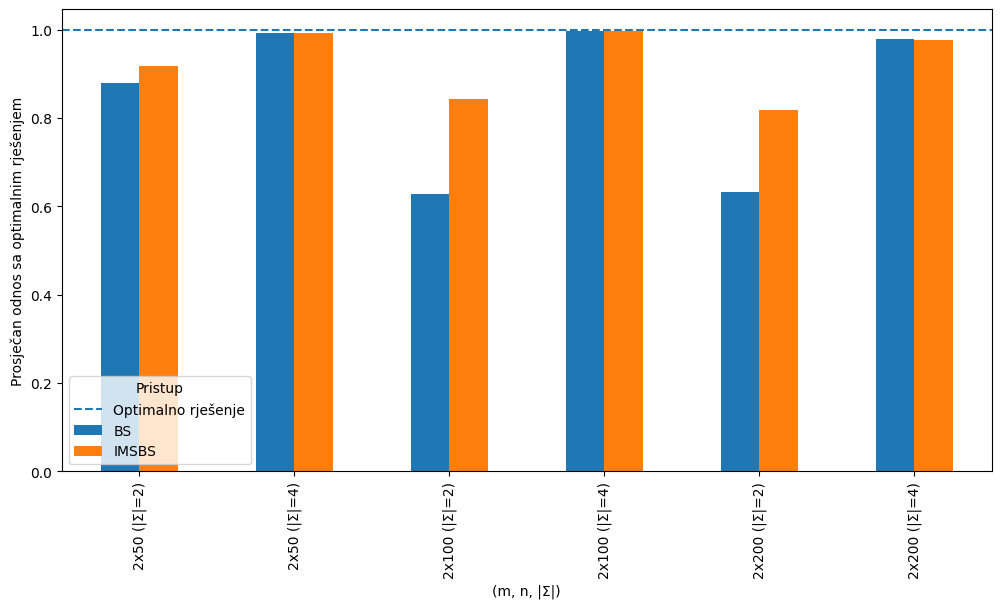

In [72]:

pivot = (
    per_instance
    .pivot(index=["number_of_sequences", "length_per_sequence", "sigma", "instance_number"],
           columns="func", values="length")
    .reset_index()
)

# --- 2) Compute ratio vs DP ---
for func in pivot.columns:
    if func not in ["number_of_sequences", "length_per_sequence", "sigma", "instance_number", "dp"]:
        pivot[f"{func}_ratio"] = pivot[func] / pivot["dp"]

print(pivot.head())

# --- 3) Histogram of ratios ---
for func in ["beam_search_glcs", "imbs_glcs"]:
    plt.figure()
    pivot[f"{func}_ratio"].hist(bins=20, alpha=0.7)
    plt.axvline(1.0, color="red", linestyle="--", label="Optimalno rješenje")
    #plt.title(f"{'BS' if func == 'beam_search_glcs' else 'IMSBS'} / Optimum")
    plt.xlabel("Odnos")
    plt.ylabel("Frekvencija")
    plt.legend()
    plt.show()

keys = ["number_of_sequences", "length_per_sequence", "sigma"]

# average ratios per (n, L, σ)
avg_ratios = (
    pivot
    .groupby(keys)
    .agg({
        "beam_search_glcs_ratio": "mean",
        "imbs_glcs_ratio": "mean",
    })
    .reset_index()
)

# 1) build a single x-axis label
avg_ratios["group"] = (
    avg_ratios["number_of_sequences"].astype(str) + "x" +
    avg_ratios["length_per_sequence"].astype(str) + " (|Σ|=" +
    avg_ratios["sigma"].astype(str) + ")"
)

# 2) set index to that label and plot the ratio columns
plot_cols = ["beam_search_glcs_ratio", "imbs_glcs_ratio"]
ax = avg_ratios.set_index("group")[plot_cols].plot(kind="bar", figsize=(12, 6))
ax.axhline(1.0, linestyle="--")
ax.set_ylabel("Prosječan odnos sa optimalnim rješenjem")
ax.set_xlabel("(m, n, |Σ|)")
#ax.set_title("Average solution quality relative to DP")
ax.legend(title="Pristup", labels=['Optimalno rješenje', 'BS', 'IMSBS'])


# Comparing BS and IMBS


In [73]:
df = all_results.copy()
df = df[df["func"].isin(["beam_search_glcs", "imbs_glcs"])].copy()

cols = [
    "sigma", "length_per_sequence", "number_of_sequences",
    "func", "heuristic", "beam_width",
    "instance_number", "length", "time_s", "feasible"
]
df = df[cols]

group_keys = [
    "sigma", "length_per_sequence", "number_of_sequences",
    "func", "heuristic", "beam_width"
]

# summary per (Σ, n, m, func, heuristic, bw)
grouped = (
    df.groupby(group_keys, as_index=False)
         .agg(
             n_instances=("instance_number", "nunique"),
             length_mean=("length", "mean"),
             length_max=("length", "max"),
             time_mean=("time_s", "mean"),
             feasible_rate=("feasible", "mean"),
         )
         .sort_values(group_keys)
         .reset_index(drop=True)
)

grouped


,sigma,length_per_sequence,number_of_sequences,func,heuristic,beam_width,n_instances,length_mean,length_max,time_mean,feasible_rate
0,2,50,2,beam_search_glcs,h2,1,10,14.7,36,0.00030,1.0
1,2,50,2,beam_search_glcs,h2,10,10,30.6,38,0.00150,1.0
2,2,50,2,beam_search_glcs,h2,50,10,33.4,38,0.00493,1.0
3,2,50,2,beam_search_glcs,h2,100,10,33.4,38,0.00645,1.0
4,2,50,2,beam_search_glcs,h2,250,10,33.6,38,0.00885,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2035,4,1000,10,imbs_glcs,h8,100,10,3.9,6,0.32145,1.0
2036,4,1000,10,imbs_glcs,h8,250,10,3.9,6,0.31998,1.0
2037,4,1000,10,imbs_glcs,h8,500,10,3.9,6,0.32504,1.0
2038,4,1000,10,imbs_glcs,h8,1000,10,3.9,6,0.31694,1.0


In [74]:
'''
gb = grouped.copy()
gb["algo_heur"] = gb["func"] + "::" + gb["heuristic"]

# loop over beam widths
for bw in sorted(gb["beam_width"].unique()):
    data_bw = gb[gb["beam_width"] == bw].copy()

    # create an x label for each instance type
    data_bw["x_label"] = (
        "Σ=" + data_bw["sigma"].astype(str) +
        " | n=" + data_bw["length_per_sequence"].astype(str) +
        " | m=" + data_bw["number_of_sequences"].astype(str)
    )

    # Pivot: rows = instance type, cols = algo+heur, values = mean length
    len_piv = data_bw.pivot(index="x_label", columns="algo_heur", values="length_mean").fillna(0.0)
    tim_piv = data_bw.pivot(index="x_label", columns="algo_heur", values="time_mean").fillna(0.0)

    # Plot mean length
    ax = len_piv.plot(kind="bar", figsize=(12, 5))
    ax.set_title(f"Mean Length — beam width {bw}")
    ax.set_xlabel("(Σ, n, m)")
    ax.set_ylabel("Mean Length")
    ax.legend(title="Algorithm+Heuristic")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot mean time
    ax = tim_piv.plot(kind="bar", figsize=(12, 5))
    ax.set_title(f"Mean Execution Time (s) — beam width {bw}")
    ax.set_xlabel("(Σ, n, m)")
    ax.set_ylabel("Mean Time (s)")
    ax.legend(title="Algorithm+Heuristic")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
'''

'\ngb = grouped.copy()\ngb["algo_heur"] = gb["func"] + "::" + gb["heuristic"]\n\n# loop over beam widths\nfor bw in sorted(gb["beam_width"].unique()):\n    data_bw = gb[gb["beam_width"] == bw].copy()\n\n    # create an x label for each instance type\n    data_bw["x_label"] = (\n        "Σ=" + data_bw["sigma"].astype(str) +\n        " | n=" + data_bw["length_per_sequence"].astype(str) +\n        " | m=" + data_bw["number_of_sequences"].astype(str)\n    )\n\n    # Pivot: rows = instance type, cols = algo+heur, values = mean length\n    len_piv = data_bw.pivot(index="x_label", columns="algo_heur", values="length_mean").fillna(0.0)\n    tim_piv = data_bw.pivot(index="x_label", columns="algo_heur", values="time_mean").fillna(0.0)\n\n    # Plot mean length\n    ax = len_piv.plot(kind="bar", figsize=(12, 5))\n    ax.set_title(f"Mean Length — beam width {bw}")\n    ax.set_xlabel("(Σ, n, m)")\n    ax.set_ylabel("Mean Length")\n    ax.legend(title="Algorithm+Heuristic")\n    plt.xticks(rotation=

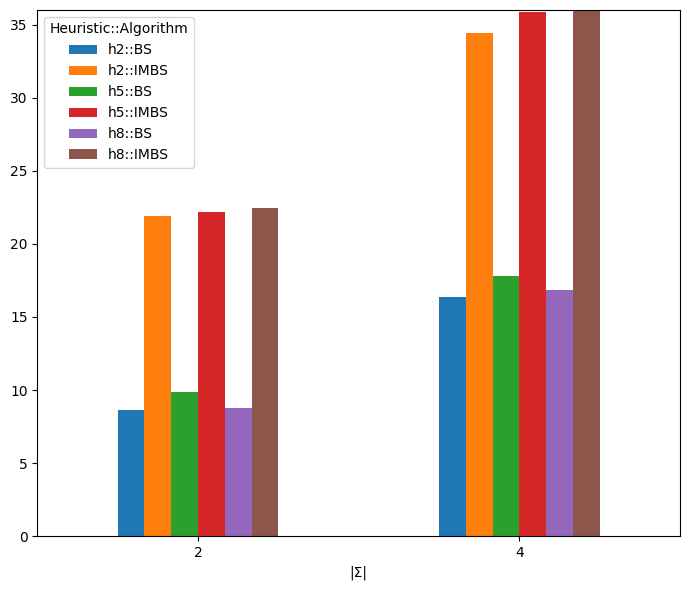

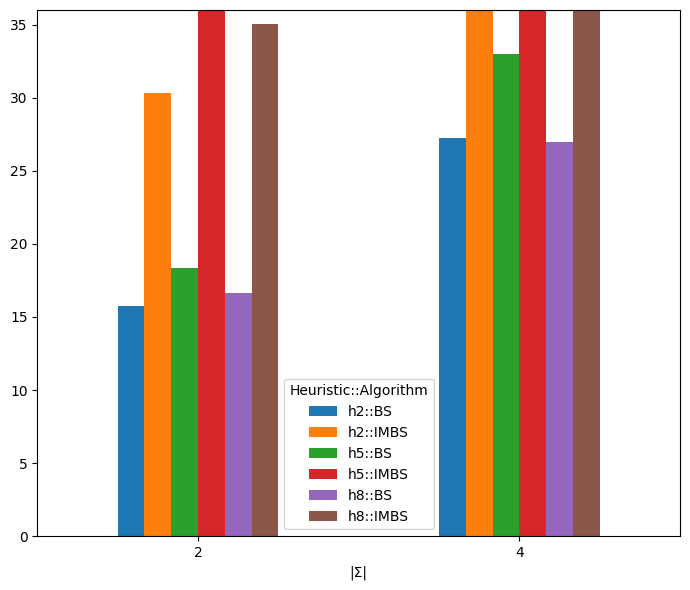

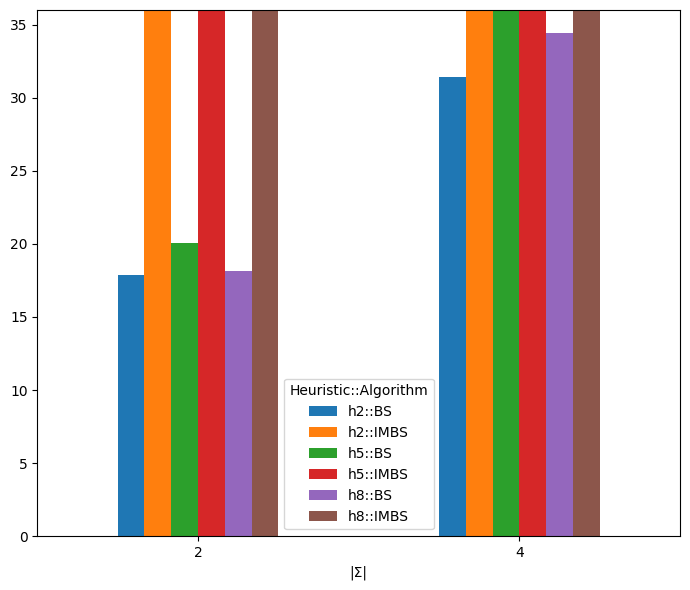

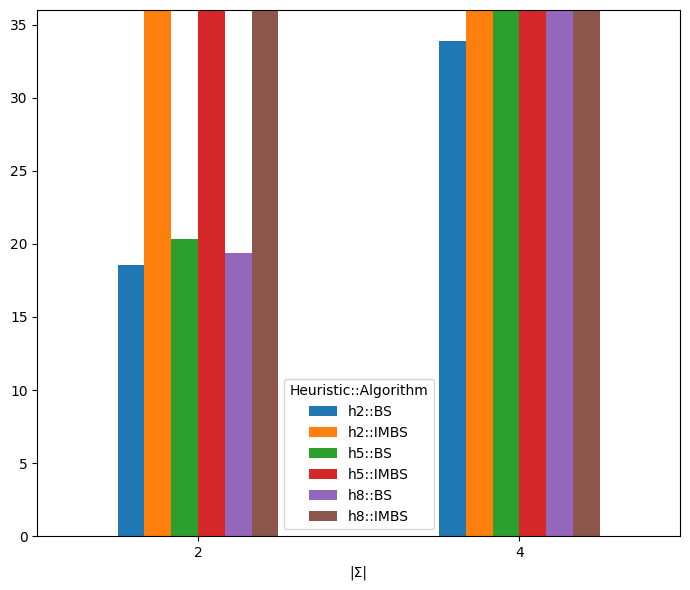

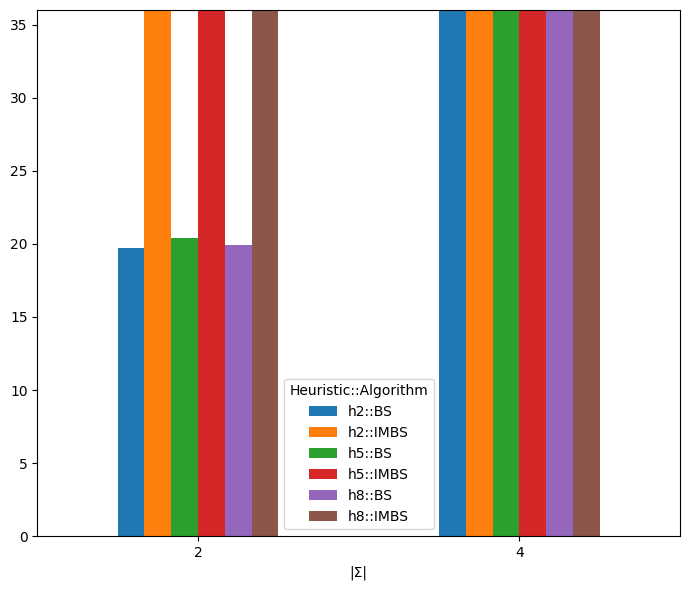

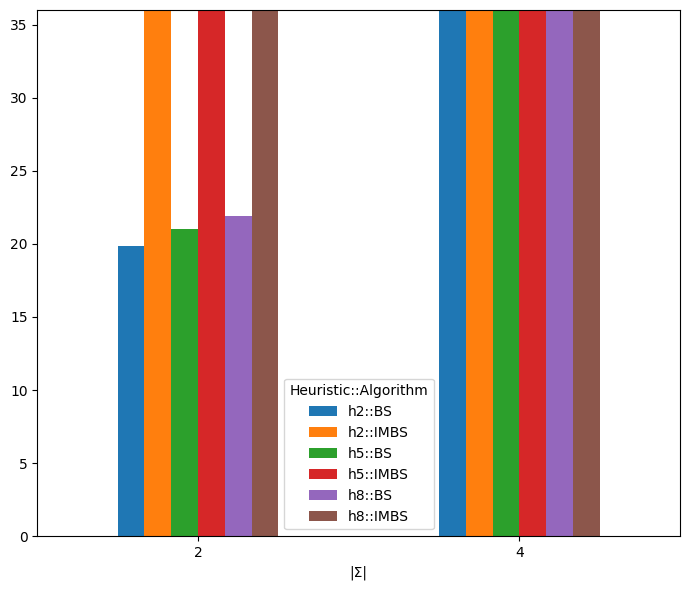

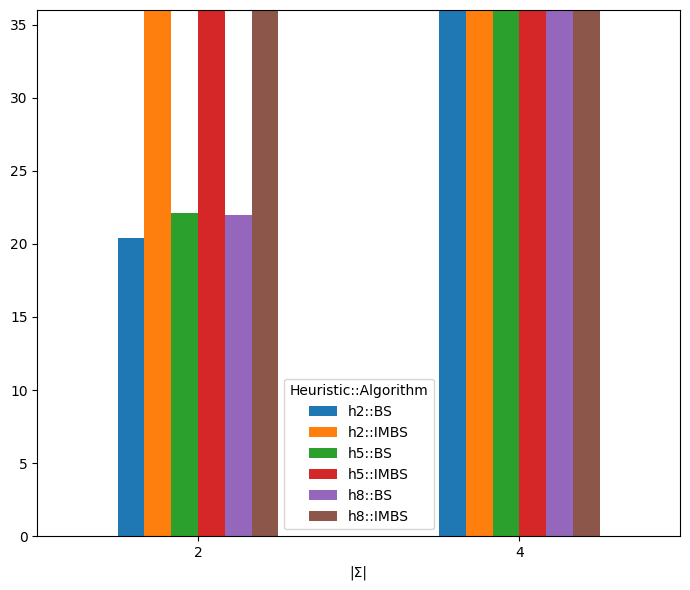

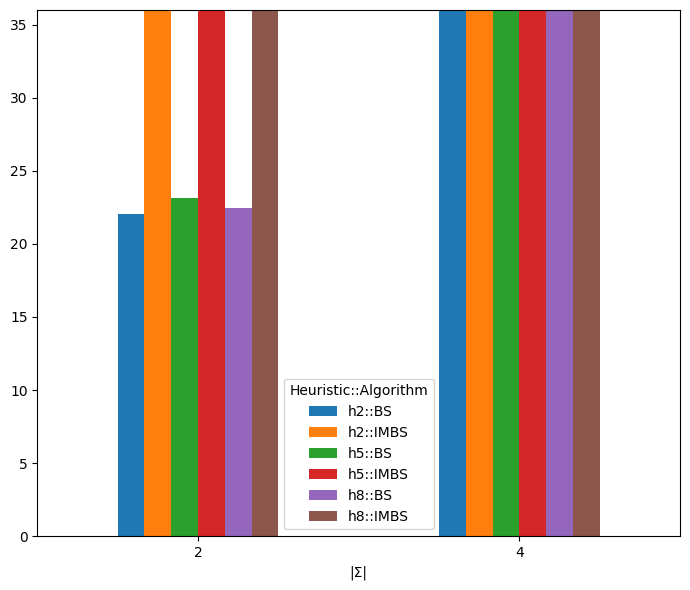

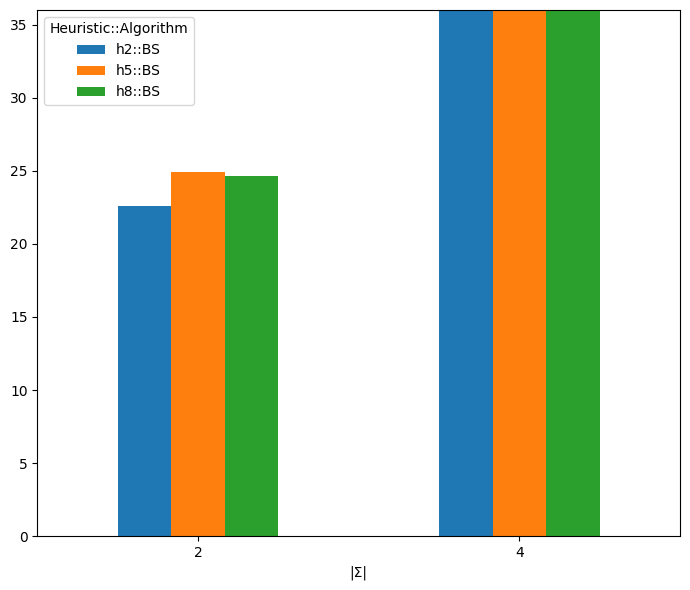

'\ngb = grouped.copy()\n\n# optional: nicer algorithm short names in legend\ndef short_alg(name: str) -> str:\n    return "BS" if name == "beam_search_glcs" else ("IMBS" if name == "imbs_glcs" else name)\n\nfor bw in sorted(gb["beam_width"].unique()):\n    data_bw = gb[gb["beam_width"] == bw].copy()\n    if data_bw.empty:\n        continue\n\n    for m in sorted(data_bw["number_of_sequences"].unique()):\n        data_bwm = data_bw[data_bw["number_of_sequences"] == m].copy()\n        if data_bwm.empty:\n            continue\n\n        # x-axis without m (since m is fixed inside this plot)\n        data_bwm["x_label"] = (\n            "Σ=" + data_bwm["sigma"].astype(str) +\n            " | n=" + data_bwm["length_per_sequence"].astype(str)\n        )\n\n        # Pivots with (heuristic, func) as columns\n        len_piv = (\n            data_bwm\n            .pivot(index="x_label", columns=["heuristic","func"], values="length_mean")\n            .fillna(0.0)\n        )\n        tim_piv = 

In [75]:
def short_alg(name: str) -> str:
    return "BS" if name == "beam_search_glcs" else ("IMBS" if name == "imbs_glcs" else name)

gb = grouped.copy()  # grouped by: sigma, length_per_sequence, number_of_sequences, func, heuristic, beam_width
# We'll aggregate length_mean across (length_per_sequence, number_of_sequences) within each sigma

for bw in sorted(gb["beam_width"].unique()):
    data_bw = gb[gb["beam_width"] == bw].copy()
    if data_bw.empty:
        continue

    # 1) Aggregate to (sigma, heuristic, func)
    agg = (
        data_bw
        .groupby(["sigma", "heuristic", "func"], as_index=False)
        .agg(length_mean=("length_mean", "mean"))
    )

    # 2) Pivot: rows = sigma, columns = (heuristic, func)
    len_piv = agg.pivot(index="sigma", columns=["heuristic", "func"], values="length_mean").fillna(0.0)

    # 3) Reorder columns: for each heuristic -> [BS, IMBS]
    ordered_cols = []
    heuristics = sorted(agg["heuristic"].unique())
    for h in heuristics:
        for f in ["beam_search_glcs", "imbs_glcs"]:
            key = (h, f)
            if key in len_piv.columns:
                ordered_cols.append(key)
    if ordered_cols:
        len_piv = len_piv[ordered_cols]

    # 4) Flatten column labels to "hX::BS/IMBS"
    len_piv.columns = [f"{h}::{short_alg(fnm)}" for (h, fnm) in len_piv.columns]

    # 5) Make x labels nicer ("Σ=2", etc.)
    len_piv.index = [f"{int(s)}" for s in len_piv.index]

    # 6) Plot
    ax = len_piv.plot(kind="bar", figsize=(7, 6))
    ax.set_ylim(0, 36)
    #ax.set_title(f"Mean Length by Sigma — beam width {bw}")
    ax.set_xlabel("|Σ|")
    #ax.set_ylabel("Mean Length")
    ax.legend(title="Heuristic::Algorithm", ncols=1)  # tweak ncols if many heuristics
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



'''
gb = grouped.copy()

# optional: nicer algorithm short names in legend
def short_alg(name: str) -> str:
    return "BS" if name == "beam_search_glcs" else ("IMBS" if name == "imbs_glcs" else name)

for bw in sorted(gb["beam_width"].unique()):
    data_bw = gb[gb["beam_width"] == bw].copy()
    if data_bw.empty:
        continue

    for m in sorted(data_bw["number_of_sequences"].unique()):
        data_bwm = data_bw[data_bw["number_of_sequences"] == m].copy()
        if data_bwm.empty:
            continue

        # x-axis without m (since m is fixed inside this plot)
        data_bwm["x_label"] = (
            "Σ=" + data_bwm["sigma"].astype(str) +
            " | n=" + data_bwm["length_per_sequence"].astype(str)
        )

        # Pivots with (heuristic, func) as columns
        len_piv = (
            data_bwm
            .pivot(index="x_label", columns=["heuristic","func"], values="length_mean")
            .fillna(0.0)
        )
        tim_piv = (
            data_bwm
            .pivot(index="x_label", columns=["heuristic","func"], values="time_mean")
            .fillna(0.0)
        )

        # Reorder columns: for each heuristic, [Beam, IMBS]
        order = []
        heuristics = sorted(data_bwm["heuristic"].unique())
        for h in heuristics:
            for f in ["beam_search_glcs", "imbs_glcs"]:
                if (h, f) in len_piv.columns:
                    order.append((h, f))
        if order:
            len_piv = len_piv[order]
            tim_piv = tim_piv[order]

        # Flatten labels to "hX::BS/IMBS"
        len_piv.columns = [f"{h}::{short_alg(fnm)}" for h, fnm in len_piv.columns]
        tim_piv.columns = [f"{h}::{short_alg(fnm)}" for h, fnm in tim_piv.columns]

        # --- Plot Mean Length ---
        ax = len_piv.plot(kind="bar", figsize=(12, 5))
        ax.set_title(f"Mean Length — bw={bw}, m={m}")
        ax.set_xlabel("(Σ, n)")
        ax.set_ylabel("Mean Length")
        ax.legend(title="Heuristic::Algorithm")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        # --- Plot Mean Time ---
        ax = tim_piv.plot(kind="bar", figsize=(12, 5))
        ax.set_title(f"Mean Execution Time (s) — bw={bw}, m={m}")
        ax.set_xlabel("(Σ, n)")
        ax.set_ylabel("Mean Time (s)")
        ax.legend(title="Heuristic::Algorithm")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
'''

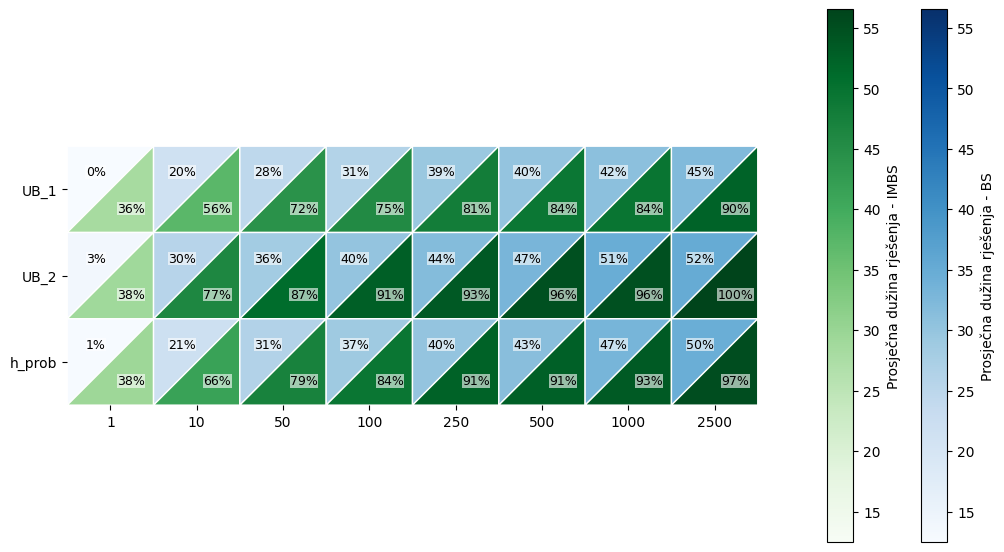

In [76]:
def draw_split_heatmap(ax,
                       mat_left, mat_right,           # numpy arrays (H x W)
                       xlabels, ylabels,
                       cmap_left="Blues", cmap_right="Greens",
                       vmin_left=None, vmax_left=None,
                       vmin_right=None, vmax_right=None,
                       annotate_percent=False,
                       fmt="{:.0f}%",                  # percent label format
                       text_kwargs=None):
    """
    Draw a split-cell heatmap: upper-left triangle = mat_left, lower-right = mat_right.
    If annotate_percent=True, writes percentages relative to a common min/max (the bounds
    used for the colorbars) so labels are consistent with colors.
    """
    H, W = mat_left.shape
    ax.set_xlim(0, W); ax.set_ylim(0, H)
    ax.invert_yaxis()  # row 0 at top

    cmapL = plt.get_cmap(cmap_left)
    cmapR = plt.get_cmap(cmap_right)

    # Defaults for color scaling
    if vmin_left  is None: vmin_left  = np.nanmin(mat_left)
    if vmax_left  is None: vmax_left  = np.nanmax(mat_left)
    if vmin_right is None: vmin_right = np.nanmin(mat_right)
    if vmax_right is None: vmax_right = np.nanmax(mat_right)

    # Use a COMMON scale for both colorbars and percent labels
    vmin_all = np.nanmin([vmin_left, vmin_right])
    vmax_all = np.nanmax([vmax_left, vmax_right])
    span = (vmax_all - vmin_all) if (vmax_all > vmin_all) else 1.0

    normL = mpl.colors.Normalize(vmin=vmin_all, vmax=vmax_all)
    normR = mpl.colors.Normalize(vmin=vmin_all, vmax=vmax_all)

    # Default text styling
    if text_kwargs is None:
        text_kwargs = dict(color="black",
                           fontsize=9,
                           ha="center", va="center",
                           bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.2))

    for i in range(H):
        for j in range(W):
            x0, y0 = j, i
            x1, y1 = j+1, i+1

            # Upper-left (left matrix)
            vL = mat_left[i, j]
            if not np.isnan(vL):
                polyL = Polygon([[x0,y0],[x1,y0],[x0,y1]],
                                closed=True, facecolor=cmapL(normL(vL)), edgecolor="white")
                ax.add_patch(polyL)

            # Lower-right (right matrix)
            vR = mat_right[i, j]
            if not np.isnan(vR):
                polyR = Polygon([[x1,y1],[x1,y0],[x0,y1]],
                                closed=True, facecolor=cmapR(normR(vR)), edgecolor="white")
                ax.add_patch(polyR)

            # Percent labels
            if annotate_percent and not np.isnan(vL):
                pctL = 100.0 * (vL - vmin_all) / span
                # position inside upper-left triangle
                ax.text(j + 0.33, i + 0.30, fmt.format(pctL), **text_kwargs)
            if annotate_percent and not np.isnan(vR):
                pctR = 100.0 * (vR - vmin_all) / span
                # position inside lower-right triangle
                ax.text(j + 0.74, i + 0.72, fmt.format(pctR), **text_kwargs)

    ax.set_xticks(np.arange(W)+0.5); ax.set_xticklabels(xlabels)
    ax.set_yticks(np.arange(H)+0.5); ax.set_yticklabels(ylabels)
    ax.set_aspect("equal")
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Return the norms so caller can build matching colorbars
    return normL, normR


def split_len_heatmap_avg(grouped_bi, value="length_mean", annotate_percent=True):
    # Average across all (sigma, L, n)
    gb = (
        grouped_bi[grouped_bi["beam_width"]<=2500]
        .groupby(["func", "heuristic", "beam_width"], as_index=False)
        .agg({value: "mean"})
    )

    beam = gb[gb["func"]=="beam_search_glcs"].pivot(index="heuristic", columns="beam_width", values=value)
    imbs = gb[gb["func"]=="imbs_glcs"].pivot(index="heuristic", columns="beam_width", values=value)

    heur = sorted(set(beam.index).union(imbs.index))
    bws  = sorted(set(beam.columns).union(imbs.columns))
    beam = beam.reindex(index=heur, columns=bws)
    imbs = imbs.reindex(index=heur, columns=bws)

    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

    ylabels = {
        "h1" : "L",
        "h2" : "UB_1",
        "h5" : "UB_2",
        "h8" : "h_prob",
        "new_h8" : "new_h8"
    }
    # Draw split cells and get norms for colorbars
    normL, normR = draw_split_heatmap(
        ax,
        beam.values, imbs.values,
        xlabels=bws, ylabels=[ylabels[x] for x in heur],
        cmap_left="Blues", cmap_right="Greens",
        # pass None to auto-compute global min/max; draw_split_heatmap will unify scales
        vmin_left=None, vmax_left=None, vmin_right=None, vmax_right=None,
        annotate_percent=annotate_percent,
        fmt="{:.0f}%"
    )

    #ax.set_title(f"Prosječna dužina rješenja — BS (plave) vs IMBS (zelene)")

    # Legends (two colorbars sharing the same global norm)
    cmap_beam = plt.get_cmap("Blues")
    cmap_imbs = plt.get_cmap("Greens")
    sm_beam = mpl.cm.ScalarMappable(cmap=cmap_beam, norm=normL)
    sm_imbs = mpl.cm.ScalarMappable(cmap=cmap_imbs, norm=normR)
    sm_beam.set_array([]); sm_imbs.set_array([])

    cbar1 = fig.colorbar(sm_beam, ax=ax, fraction=0.046, pad=0.04)
    cbar1.set_label("Prosječna dužina rješenja - BS")
    cbar2 = fig.colorbar(sm_imbs, ax=ax, fraction=0.046, pad=0.10)
    cbar2.set_label("Prosječna dužina rješenja - IMBS")

    plt.show()

split_len_heatmap_avg(grouped, value="length_mean", annotate_percent=True)

In [77]:
df = all_results.copy()

# Keep only beam search & IMBS
df = df[df["func"].isin(["beam_search_glcs", "imbs_glcs"])].copy()

# Define method groups
def method_group(row):
    if row["func"] == "beam_search_glcs" and row["beam_width"] == 1:
        return "GREEDY"
    if row["func"] == "beam_search_glcs" and row["beam_width"] == 10000:
        return "BS"
    if row["func"] == "imbs_glcs" and row["beam_width"] == 500:
        return "IMBS"
    return None

df["method"] = df.apply(method_group, axis=1)
df = df[df["method"].isin(["GREEDY","BS","IMBS"])].copy()

# Instance signature
keys_inst = ["number_of_sequences", "length_per_sequence", "sigma", "instance_number", "method"]

# Per-instance aggregation (average within an instance over all runs of the method bucket)
per_instance = (
    df.groupby(keys_inst, as_index=False)
      .agg(length=("length", "mean"), time_s=("time_s", "mean"))
)

# Group to (m, n, |Σ|, method) and compute table cells: mean over instances
keys_group = ["number_of_sequences", "length_per_sequence", "sigma", "method"]
tbl_long = (
    per_instance.groupby(keys_group, as_index=False)
                .agg(obj_mean=("length", "mean"),
                     time_mean=("time_s", "mean"))
)

# Pivot to wide: columns = methods (BS-1, BS, IMBS)
wide = tbl_long.pivot(index=["number_of_sequences","length_per_sequence","sigma"],
                      columns="method",
                      values=["obj_mean","time_mean"])

# Ensure columns exist even if some buckets are missing
for m in ["GREEDY","BS","IMBS"]:
    if ("obj_mean", m) not in wide.columns:
        wide[("obj_mean", m)] = np.nan
    if ("time_mean", m) not in wide.columns:
        wide[("time_mean", m)] = np.nan

# Order columns and flatten names to match LaTeX order
wide = wide[[
    ("obj_mean","GREEDY"), ("time_mean","GREEDY"),
    ("obj_mean","BS"),   ("time_mean","BS"),
    ("obj_mean","IMBS"), ("time_mean","IMBS"),
]]

wide.columns = [
    r"BS-1 $\overline{obj}$", r"BS-1 $\overline{t}[s]$",
    r"BS $\overline{obj}$",   r"BS $\overline{t}[s]$",
    r"IMBS $\overline{obj}$", r"IMBS $\overline{t}[s]$",
]

# Bring index back as columns and rename to LaTeX headers
df_table = wide.reset_index().rename(columns={
    "number_of_sequences": r"$m$",
    "length_per_sequence": r"$n$",
    "sigma": r"$|\Sigma|$"
})

df_table = df_table.round({
    r"BS-1 $\overline{obj}$": 2, r"BS-1 $\overline{t}[s]$": 2,
    r"BS $\overline{obj}$":   2, r"BS $\overline{t}[s]$":   2,
    r"IMBS $\overline{obj}$": 2, r"IMBS $\overline{t}[s]$": 2,
})

# Sort rows in a sensible order
df_table = df_table.sort_values([r"$m$", r"$n$", r"$|\Sigma|$"]).reset_index(drop=True)

#latex = df_table.to_latex(index=False, escape=False, column_format="lll|rr|rr|rr")
#print(latex)
df_table

,$m$,$n$,$|\Sigma|$,BS-1 $\overline{obj}$,BS-1 $\overline{t}[s]$,BS $\overline{obj}$,BS $\overline{t}[s]$,IMBS $\overline{obj}$,IMBS $\overline{t}[s]$
0,2,50,2,16.93,0.00,33.60,0.01,35.00,0.03
1,2,50,4,24.50,0.00,30.10,0.59,30.10,0.09
2,2,100,2,19.73,0.00,48.90,1.12,65.10,0.31
3,2,100,4,50.47,0.00,62.07,7.38,61.63,0.51
4,2,200,2,22.30,0.00,97.60,9.11,121.47,2.34
5,2,200,4,53.37,0.01,118.97,23.80,115.80,2.82
6,2,500,2,20.10,0.01,64.80,11.38,132.67,10.43
7,2,500,4,47.47,0.02,194.03,83.94,213.57,23.37
8,2,1000,2,27.07,0.05,109.37,64.11,189.00,45.05
9,2,1000,4,69.67,0.07,169.60,172.08,291.87,65.10


In [78]:
df = df_table.copy()

import pandas as pd
import numpy as np

COLS = {
    "$m$": "m",
    "$n$": "n",
    "$|\Sigma|$": "sigma",
    "BS-1 $\overline{obj}$": "bs1_obj",
    "BS-1 $\overline{t}[s]$": "bs1_time",
    "BS $\overline{obj}$": "bs_obj",
    "BS $\overline{t}[s]$": "bs_time",
    "IMBS $\overline{obj}$": "imbs_obj",
    "IMBS $\overline{t}[s]$": "imbs_time",
}
df = df.rename(columns=COLS).copy()

# Ensure correct dtypes
for c in ["m","n","sigma"]:
    df[c] = df[c].astype(int)
for c in ["bs1_obj","bs1_time","bs_obj","bs_time","imbs_obj","imbs_time"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Helper summaries -------------------------------------------------------
def fmt(x, digits=2):
    if pd.isna(x): return "NA"
    s = f"{x:.{digits}f}"
    return s.rstrip("0").rstrip(".") if "." in s else s

def compute_summary(df: pd.DataFrame):
    out = {}

    # 1) Who wins on quality (max obj) per row
    objs = df[["bs1_obj","bs_obj","imbs_obj"]]
    max_obj = objs.max(axis=1)
    imbs_best = (df["imbs_obj"] == max_obj).sum()
    bs_best   = (df["bs_obj"]   == max_obj).sum()
    bs1_best  = (df["bs1_obj"]  == max_obj).sum()
    out["count_best_obj"] = {"IMBS": int(imbs_best), "BS": int(bs_best), "GREEDY": int(bs1_best)}

    # 2) Average gain (IMBS − BS) overall and stratified by n
    df["gain_imbs_minus_bs"] = df["imbs_obj"] - df["bs_obj"]
    out["avg_gain_overall"] = df["gain_imbs_minus_bs"].mean()
    out["avg_gain_overall_perc"] = out["avg_gain_overall"] / df["bs_obj"].mean() * 100.0 if df["bs_obj"].mean() != 0 else np.nan
    out["avg_gain_by_n"] = df.groupby("n")["gain_imbs_minus_bs"].mean().to_dict()
    out["avg_gain_by_n_perc"] = {
        int(n): (g / df.loc[df["n"] == n, "bs_obj"].mean() * 100.0 if df.loc[df["n"] == n, "bs_obj"].mean() != 0 else np.nan)
        for n, g in out["avg_gain_by_n"].items()
    }

    # 3) Biggest single win (value and where)
    idx_max = df["gain_imbs_minus_bs"].idxmax()
    out["max_gain_value"] = df.loc[idx_max, "gain_imbs_minus_bs"]
    out["max_gain_where"] = {
        "m": int(df.loc[idx_max, "m"]),
        "n": int(df.loc[idx_max, "n"]),
        "sigma": int(df.loc[idx_max, "sigma"]),
        "imbs_obj": float(df.loc[idx_max, "imbs_obj"]),
        "bs_obj": float(df.loc[idx_max, "bs_obj"]),
    }

    # 4) Time summaries (median & mean) for BS vs IMBS
    out["time_median"] = {"BS": float(df["bs_time"].median()), "IMBS": float(df["imbs_time"].median())}
    out["time_mean"]   = {"BS": float(df["bs_time"].mean()),   "IMBS": float(df["imbs_time"].mean())}

    # 5) Outliers and heavy tail checks
    thr = 10.0
    out["count_time_over_10s"] = {
        "BS": int((df["bs_time"] > thr).sum()),
        "IMBS": int((df["imbs_time"] > thr).sum())
    }
    out["rows_time_over_10s"] = {
        "BS": df.loc[df["bs_time"] > thr, ["m","n","sigma","bs_time"]].to_dict(orient="records"),
        "IMBS": df.loc[df["imbs_time"] > thr, ["m","n","sigma","imbs_time"]].to_dict(orient="records"),
    }
    out["time_max"] = {"BS": float(df["bs_time"].max()), "IMBS": float(df["imbs_time"].max())}

    # 6) Where is IMBS faster than BS?
    faster = (df["imbs_time"] < df["bs_time"])
    out["imbs_faster_count"] = int(faster.sum())
    out["imbs_faster_by_n_mean_delta"] = (
        (df["bs_time"] - df["imbs_time"]).groupby(df["n"]).mean().to_dict()
    )

    return out

summary = compute_summary(df)

# ---- Pretty print summary ---------------------------------------------------
print("Best obj count (rows won):", summary["count_best_obj"])
print("Average gain (IMBS - BS) overall:", fmt(summary["avg_gain_overall"]))
print("Average gain % (IMBS - BS) overall:", fmt(summary["avg_gain_overall_perc"]), "%")
print("Average gain by n:", {k: fmt(v) for k, v in summary["avg_gain_by_n"].items()})
print("Average gain % by n:", {k: fmt(v) + "%" for k, v in summary["avg_gain_by_n_perc"].items()})
print("Max single gain:", fmt(summary["max_gain_value"]), "at", summary["max_gain_where"])
print("Median times (s):", {k: fmt(v) for k, v in summary["time_median"].items()})
print("Mean times (s):", {k: fmt(v) for k, v in summary["time_mean"].items()})
print(">10s counts:", summary["count_time_over_10s"])
print("Max times (s):", {k: fmt(v) for k, v in summary["time_max"].items()})
print("IMBS faster count:", summary["imbs_faster_count"])   
print("IMBS time advantage by n (mean BS-IMBS, s):", {k: fmt(v) for k, v in summary["imbs_faster_by_n_mean_delta"].items()})


Best obj count (rows won): {'IMBS': 38, 'BS': 4, 'GREEDY': 0}
Average gain (IMBS - BS) overall: 16.57
Average gain % (IMBS - BS) overall: 46.38 %
Average gain by n: {50: '3.3', 100: '8.8', 200: '11.78', 500: '23.14', 1000: '35.83'}
Average gain % by n: {50: '21.96%', 100: '39.2%', 200: '28.36%', 500: '49.16%', 1000: '68.16%'}
Max single gain: 122.27 at {'m': 2, 'n': 1000, 'sigma': 4, 'imbs_obj': 291.87, 'bs_obj': 169.6}
Median times (s): {'BS': '0.04', 'IMBS': '0.21'}
Mean times (s): {'BS': '13.92', 'IMBS': '6.4'}
>10s counts: {'BS': 8, 'IMBS': 6}
Max times (s): {'BS': '172.08', 'IMBS': '65.1'}
IMBS faster count: 14
IMBS time advantage by n (mean BS-IMBS, s): {50: '0.05', 100: '0.93', 200: '4.37', 500: '9.55', 1000: '22.69'}
